In [36]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import yaml
from torch.utils.data import WeightedRandomSampler
import torch.nn.functional as F

from core.model import ConvEncoder
from core.jepa_dataset import JEPA_Dataset

DEVICE = (
    torch.device("cuda")
    if torch.cuda.is_available()
    else torch.device("mps")
    if torch.backends.mps.is_available()
    else torch.device("cpu")
)

In [2]:
CONFIG_PATH = "config.yml"

print("📖 Loading configuration...")
with open(CONFIG_PATH, "r") as file:
    config = yaml.safe_load(file)

📖 Loading configuration...


In [3]:
print("📦 Loading raw data...")
raw_data = torch.load(config["paths"]["preprocessed_data"])
caseids = torch.load(config["paths"]["preprocessed_ids"]).numpy()
clinical_df = pd.read_csv(config["paths"]["clinical_info_file"])

📦 Loading raw data...


In [4]:
# Compute embeddings
print("🧠 Extracting embeddings from JEPA model...")
encoder = ConvEncoder(config)

model_name = f'{config["paths"]["model_dir"]}/{config["evaluation"]["model_name"]}'

state_dict = torch.load(model_name, map_location=DEVICE)
encoder.load_state_dict(
    {
        k.replace("encoder_context.", ""): v
        for k, v in state_dict.items()
        if "encoder_context" in k
    }
)
encoder.to(DEVICE)
encoder.eval()

dataset =JEPA_Dataset(raw_data)
loader = DataLoader(dataset, batch_size=1024, shuffle=False)

all_embeddings = []
with torch.no_grad():
    for batch in tqdm(loader):
        batch = batch.to(DEVICE)
        emb = encoder(batch)
        all_embeddings.append(emb.cpu())

X = torch.cat(all_embeddings).numpy()
print(f"✅ Saved embeddings.")

🧠 Extracting embeddings from JEPA model...


100%|██████████| 2173/2173 [00:22<00:00, 96.39it/s] 


✅ Saved embeddings.


In [24]:
# AGE BUCKETS

bins = list(range(0, 101, 10))  # Define age buckets (0-9, 10-19, ..., 90-99)
labels = list(range(len(bins) - 1))  # Assign integer classes to each bucket

clinical_df['age_bucket'] = pd.cut(clinical_df['age'], bins=bins, labels=labels, right=False)
age = clinical_df['age_bucket'].astype(int).values  # Convert to integer array

# BMI BUCKETS
bins = pd.IntervalIndex.from_tuples([(0, 18.5), (18.5, 25), (25, 30), (30, 35), (35, 40), (40, 100)])
bmi_labels = [0, 1, 2, 3, 4]  # Integer encoding for each category

# Create a new column in clinical_df for BMI categories
clinical_df['bmi_category'] = pd.cut(clinical_df['bmi'], bins=bins, labels=bmi_labels, right=False)

# Convert the BMI categories to an integer array
bmi = clinical_df['bmi_category'].cat.codes.values

# SEX
sex = (clinical_df['sex'] == 'M').astype(int).values

# y = np.stack([age, bmi, sex], axis=1)

# # Repeat each row in y based on the count of each caseid in caseids
y = np.array(bmi).reshape((-1, 1)) # Use only BMI for classification
caseid_to_index = {cid: i for i, cid in enumerate(clinical_df["caseid"])}
Y = np.array([y[caseid_to_index[cid]] for cid in caseids])

In [38]:
# --- Dataset ---
class EmbeddingDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.long)
        self.indices = np.arange(len(self.Y))

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx], self.indices[idx]

split_caseids = False
if split_caseids:
    # Split caseids into train, validation, and test sets
    unique_caseids = np.unique(caseids)
    caseids_train, caseids_temp = train_test_split(unique_caseids, test_size=0.3, random_state=42)
    caseids_val, caseids_test = train_test_split(caseids_temp, test_size=2/3, random_state=42)  # 10% validation, 20% test

    # Create masks for train, validation, and test splits
    train_mask = np.isin(caseids, caseids_train)
    val_mask = np.isin(caseids, caseids_val)
    test_mask = np.isin(caseids, caseids_test)

    # Split X and Y based on the masks
    X_train, X_val, X_test = X[train_mask], X[val_mask], X[test_mask]
    Y_train, Y_val, Y_test = Y[train_mask], Y[val_mask], Y[test_mask]
else:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

train_dataset = EmbeddingDataset(X_train, Y_train)
val_dataset = EmbeddingDataset(X_val, Y_val)
test_dataset = EmbeddingDataset(X_test, Y_test)

In [39]:
import numpy as np

sample_weights = np.ones(len(Y_train))

for task_idx in range(Y_train.shape[1]):
    labels = Y_train[:, task_idx]
    class_counts = np.bincount(labels)
    class_freq = class_counts[labels]  # class_freq[i] = freq of class of sample i
    task_weights = 1.0 / (class_freq + 1e-6)  # avoid div by zero
    sample_weights += task_weights

sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

In [ ]:
# --- MLP Classifier ---
class MLPClassifierTorch(nn.Module):
    def __init__(self, input_dim, output_dims):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dims),
        )
        self.output_dims = output_dims

    def forward(self, x):
        logits = self.net(x)
        return logits

# --- Training Loop with Early Stopping ---
def train_classifier(model, train_dataset, val_dataset, num_epochs, batch_size, learning_rate, device, patience=20):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.to(device)
    best_model_state = None
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        for X_batch, Y_batch, idx in train_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device).float()
            optimizer.zero_grad()

            batch_sample_weights = torch.tensor(sample_weights[idx], dtype=torch.float32).to(device)

            output = model(X_batch)

            weighted_loss = (F.cross_entropy(output, Y_batch) * batch_sample_weights).mean()
            weighted_loss.backward()
            optimizer.step()

            total_train_loss += weighted_loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for X_batch, Y_batch, idx in val_loader:
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device).float()
                batch_sample_weights = torch.tensor(sample_weights[idx], dtype=torch.float32).to(device)

                output = model(X_batch)
                weighted_loss = ( F.cross_entropy(output, Y_batch) * batch_sample_weights).mean()
                total_val_loss += weighted_loss.item()
                
        avg_val_loss = total_val_loss / len(val_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Check for improvement
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        # Early stopping
        if epochs_without_improvement >= patience:
            print("Early stopping triggered.")
            break

    # Load the best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    print("Training complete. Best validation loss:", best_val_loss)

# --- Model Initialization ---
input_dim = train_dataset.X.shape[1]
# output_dims = [len(labels), len(bmi_labels), 2]  # Number of classes for each variable
model = MLPClassifierTorch(input_dim, 1)

# --- Training ---
train_classifier(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    num_epochs=20,
    batch_size=512,
    learning_rate=0.001,
    device=DEVICE,
)

torch.Size([512, 1])
torch.Size([512, 1]) torch.Size([512, 1])
torch.Size([512, 1])
torch.Size([512, 1]) torch.Size([512, 1])
torch.Size([512, 1])
torch.Size([512, 1]) torch.Size([512, 1])
torch.Size([512, 1])
torch.Size([512, 1]) torch.Size([512, 1])
torch.Size([512, 1])
torch.Size([512, 1]) torch.Size([512, 1])
torch.Size([512, 1])
torch.Size([512, 1]) torch.Size([512, 1])
torch.Size([512, 1])
torch.Size([512, 1]) torch.Size([512, 1])
torch.Size([512, 1])
torch.Size([512, 1]) torch.Size([512, 1])
torch.Size([512, 1])
torch.Size([512, 1]) torch.Size([512, 1])
torch.Size([512, 1])
torch.Size([512, 1]) torch.Size([512, 1])
torch.Size([512, 1])
torch.Size([512, 1]) torch.Size([512, 1])
torch.Size([512, 1])
torch.Size([512, 1]) torch.Size([512, 1])
torch.Size([512, 1])
torch.Size([512, 1]) torch.Size([512, 1])
torch.Size([512, 1])
torch.Size([512, 1]) torch.Size([512, 1])
torch.Size([512, 1])
torch.Size([512, 1]) torch.Size([512, 1])
torch.Size([512, 1])
torch.Size([512, 1]) torch.Size([5

KeyboardInterrupt: 

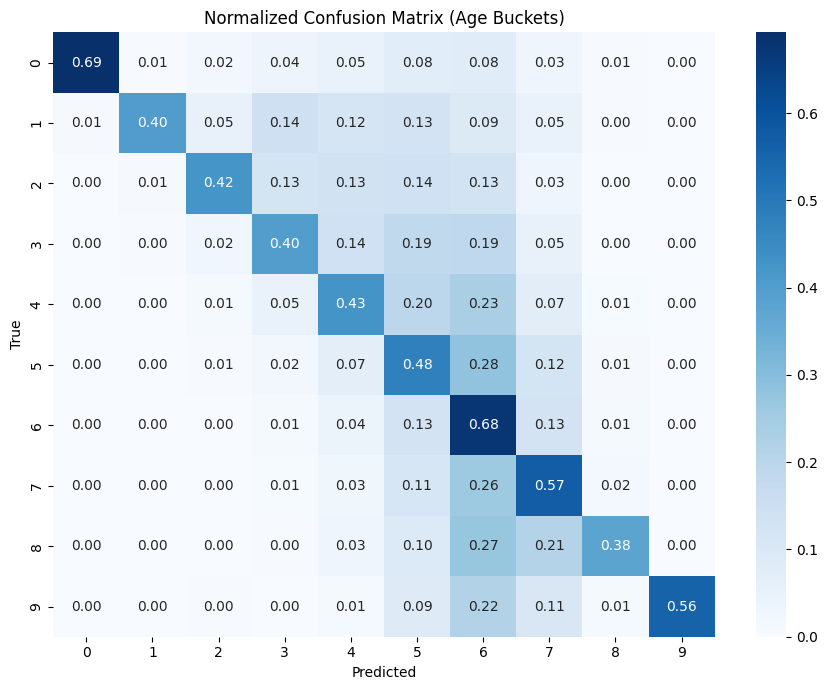

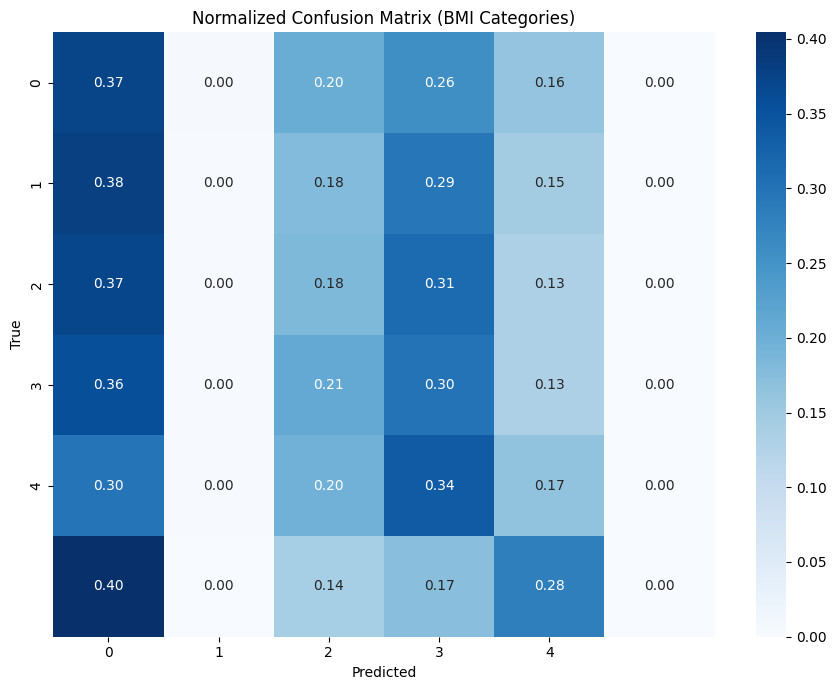

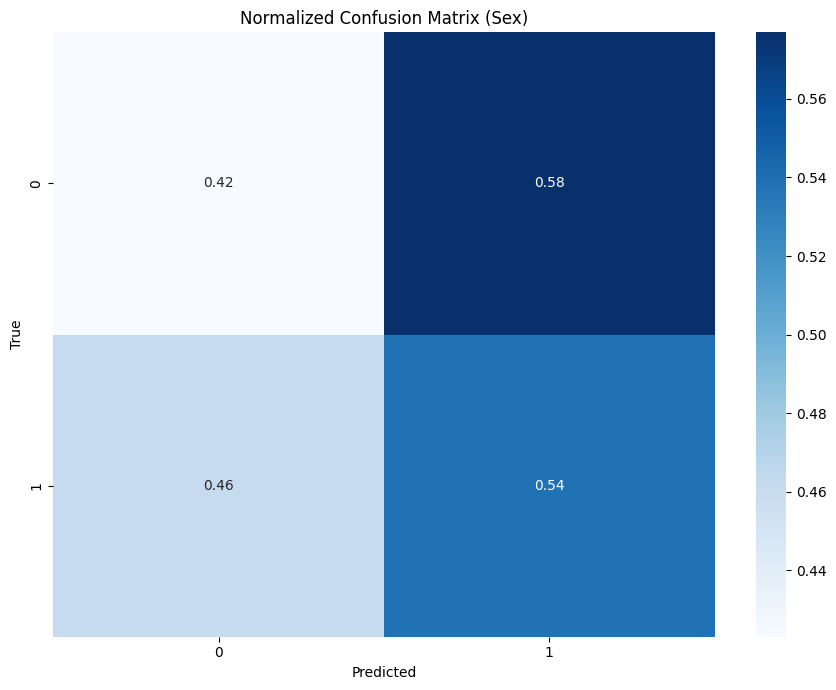

In [11]:
def plot_confusion_matrix(conf, labels, title, xlabel, ylabel):
    plt.figure(figsize=(9, 7))
    sns.heatmap(
        conf,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
    )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# --- Evaluate Classifier ---
def evaluate_classifier(model, test_dataset, output_dims, device):
    test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for X_batch, Y_batch in test_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            outputs = model(X_batch)
            preds = [torch.argmax(output, dim=1).cpu().numpy() for output in outputs]
            all_preds.append(np.stack(preds, axis=1))
            all_targets.append(Y_batch.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    return all_preds, all_targets

# Get predictions and true labels
preds, targets = evaluate_classifier(model, train_dataset, output_dims, DEVICE)

# Plot confusion matrices for each variable
variable_names = ["Age Buckets", "BMI Categories", "Sex"]
for i, (name, dim_labels) in enumerate(zip(variable_names, [labels, bmi_labels, [0, 1]])):
    conf_matrix = confusion_matrix(targets[:, i], preds[:, i], normalize="true")
    plot_confusion_matrix(
        conf_matrix,
        dim_labels,
        title=f"Normalized Confusion Matrix ({name})",
        xlabel="Predicted",
        ylabel="True",
    )
